In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
sys.path.append('/Users/w76m851/github_workspace/spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow
from spicy_snow.retrieval import retrieval_from_parameters


In [19]:
# %%time
dfdfd
files = sorted(glob('/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/*.nc'))
opt_params = pd.read_csv('../../scripts/optimize/rmse_out/optimization_results.csv', index_col=0)
results_rmse = pd.DataFrame(index=opt_params.index, columns=[i.split('-')[0]+'_params' for i in opt_params.index])
results_bias = pd.DataFrame(index=opt_params.index, columns=[i.split('-')[0]+'_params' for i in opt_params.index])
opt_params.index = [i.split('-')[0]+'_params' for i in opt_params.index]

for f in files:
    ds_ = xr.open_dataset(f).load()
    ds_name = f.split('stacks/')[-1].split('.')[0]
    ds = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    td = abs(pd.to_datetime(ds.time) - pd.to_datetime(ds.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = ds.time[closest_ts_idx]
    
    for col, (a, b, c) in opt_params[['A_opt','B_opt','C_opt']].iterrows():
        ds_param = retrieval_from_parameters(ds, A=a, B=b, C=c).sel(time=closest_ts)
        mask_wet = ~(pd.isnull(ds_param['lidar-sd']) | pd.isnull(ds_param['snow_depth']) | ds_param['wet_snow'].astype(bool))
        diff_wet = ds_param['lidar-sd'].where(mask_wet) - ds_param['snow_depth'].where(mask_wet)
        rmse = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
        results_rmse.loc[ds_name, col] = rmse
        results_bias.loc[ds_name, col] = diff_wet.mean()


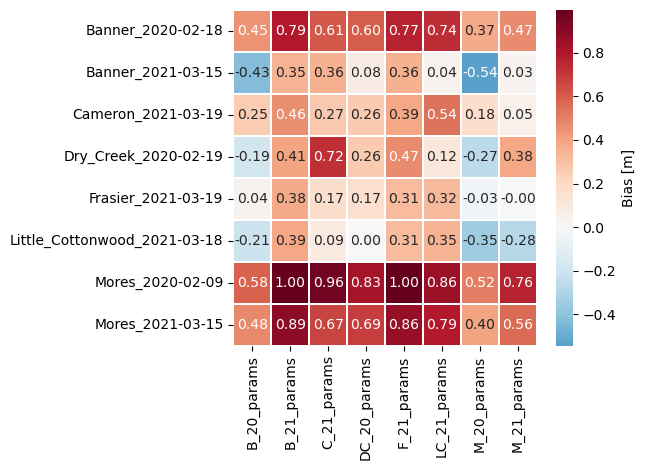

In [26]:
results_rmse = pd.read_csv('../../scripts/optimize/rmse_out/site_specific_rmse.csv', index_col=0)
results_bias = pd.read_csv('../../scripts/optimize/rmse_out/site_specific_bias.csv', index_col=0)
results_rmse.columns=['B_20_params','B_21_params','C_21_params','DC_20_params',
                      'F_21_params','LC_21_params','M_20_params','M_21_params']
results_bias.columns=['B_20_params','B_21_params','C_21_params','DC_20_params',
                      'F_21_params','LC_21_params','M_20_params','M_21_params']


import seaborn
# fig, ax = plt.subplots()
# seaborn.heatmap(results_rmse, cmap='Reds', annot=True, 
#                 linewidths=0.2, cbar_kws={'label':'RMSE [m]'}, ax=ax)
# plt.tight_layout()
# fig.savefig('../../images/site_specific_params/rmse_heatmap.png', dpi=300)

# fig, ax = plt.subplots()
# seaborn.heatmap(results_bias, cmap='RdBu_r', annot=True, fmt='.2f', center=0,
#                 linewidths=0.2, cbar_kws={'label':'Bias [m]'}, ax=ax)
# plt.tight_layout()
# fig.savefig('../../images/site_specific_params/bias_heatmap.png', dpi=300)


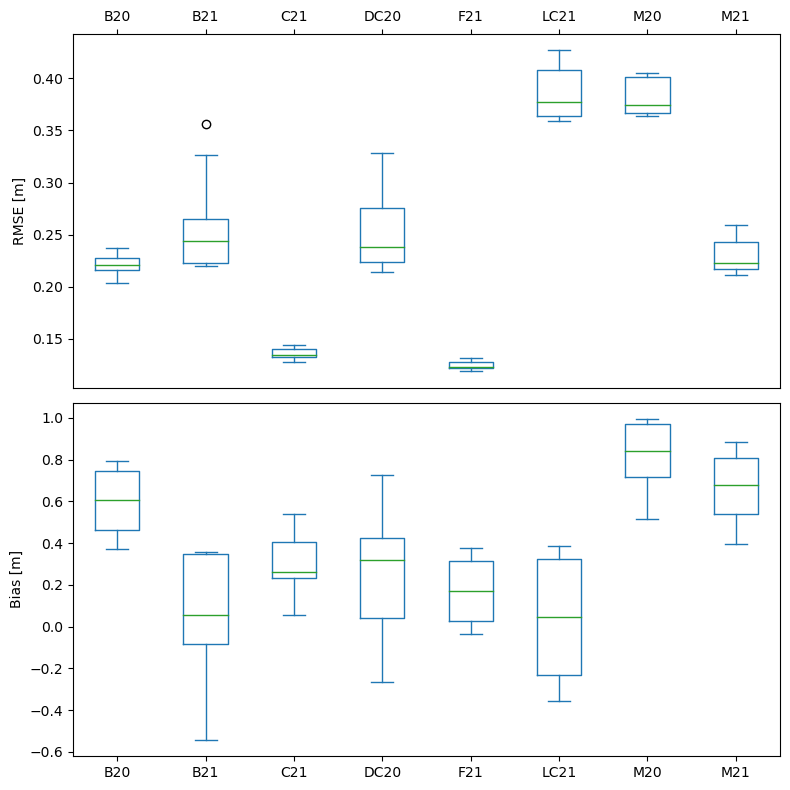

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(8,8))
results_rmse.T.plot.box(ax=ax[0])
results_bias.T.plot.box(ax=ax[1])

ax[0].set_ylabel('RMSE [m]')
ax[1].set_ylabel('Bias [m]')

ax[0].set_xticklabels(['B20','B21','C21','DC20','F21','LC21','M20','M21'])
ax[1].set_xticklabels(['B20','B21','C21','DC20','F21','LC21','M20','M21'])
ax[0].tick_params(labelbottom=False, bottom=False, labeltop=True, top=True)

plt.tight_layout()
fig.savefig('../../images/site_specific_params/boxplots.png', dpi=300)


In [ ]:
# Create parameter space
A = np.arange(1, 3.1, 0.5)
B = np.arange(0, 1.01, 0.1)
C = np.arange(0, 1.001, 0.01)

for f in files:
    ds_name = f.split('stacks/')[-1].split('.')[0]
    if 'Frasier_2021' not in ds_name:
        continue
    print(datetime.now(), f' -- starting {ds_name}')
    # Open dataset 
    ds_ = xr.open_dataset(f).load()
    dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = dataset.time[closest_ts_idx]
    # Initialize RMSE arrays
    rmse_wet_flag = xr.DataArray(np.empty((len(A), len(B), len(C)))*np.nan,
                        coords=(A, B, C), dims=('A','B','C'))
    rmse_no_flag = xr.DataArray(np.empty((len(A), len(B), len(C)))*np.nan,
                        coords=(A, B, C), dims=('A','B','C'))
    
    # Brute-force loop
    for a in A:
        ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
        for b in B:
            ds = calc_delta_gamma(ds, B=b, inplace=False)
            for c in C:
                # print(f'A={a}; B={b}; C={c}')
                ds = clip_delta_gamma_outlier(ds)
                ds = calc_snow_index(ds)
                ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
                ds = id_newly_wet_snow(ds)
                ds = id_wet_negative_si(ds)
                ds = id_newly_frozen_snow(ds)
                ds = flag_wet_snow(ds)
                # Compare snow depths - mask wet snow
                mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
                        ds['wet_snow'].sel(time=closest_ts).astype(bool))
                diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
                rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
                rmse_wet_flag.loc[a, b, c] = rmse_wet
                # Compare snow depths - no wet snow mask
                mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
                diff = ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)
                rmse = float(np.sqrt((diff**2).sum()/len(diff.values.flatten())))
                rmse_no_flag.loc[a,b,c] = rmse

    # After loop, save RMSE results per file
    rmse_wet_flag.to_netcdf(f'rmse_out/{ds_name}_wet_flag.nc')
    rmse_no_flag.to_netcdf(f'rmse_out/{ds_name}_no_flag.nc')
    

In [ ]:
# %%time
files = sorted(glob('/Users/w76m851/OneDrive - Montana State University/spicy_s1_stacks/*.nc'))

# Create parameter space
A = [2]
B = [0.5]
C = [0.44]

ds_list = []
rmse_default = []

for f in files:
    ds_name = f.split('stacks/')[-1].split('.')[0]
    print(datetime.now(), f' -- starting {ds_name}')
    # Open dataset 
    ds_ = xr.open_dataset(f).load()
    dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]
    td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
    closest_ts_idx = np.where(td == td.min())[0][0]
    closest_ts = dataset.time[closest_ts_idx]
    
    # Brute-force loop
    for a in A:
        ds = calc_delta_cross_ratio(dataset, A=a, inplace=False)
        for b in B:
            ds = calc_delta_gamma(ds, B=b, inplace=False)
            for c in C:
                # print(f'A={a}; B={b}; C={c}')
                ds = clip_delta_gamma_outlier(ds)
                ds = calc_snow_index(ds)
                ds = calc_snow_index_to_snow_depth(ds, C=c, inplace=False)
                ds = id_newly_wet_snow(ds)
                ds = id_wet_negative_si(ds)
                ds = id_newly_frozen_snow(ds)
                ds = flag_wet_snow(ds)
                # Compare snow depths - mask wet snow
                mask_wet = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)) | 
                        ds['wet_snow'].sel(time=closest_ts).astype(bool))
                diff_wet = ds['lidar-sd'].where(mask_wet) - ds['snow_depth'].sel(time=closest_ts).where(mask_wet)
                rmse_wet = float(np.sqrt((diff_wet**2).sum()/len(diff_wet.values.flatten())))
                rmse_default.append(rmse_wet)
                ds_list.append(ds_name)



res_default = pd.Series(rmse_default, index=ds_list)
res_default

In [ ]:
rmse_default

In [ ]:
results = sorted(glob('rmse_out/*.nc'))
res_df = pd.DataFrame(res_default, columns=['rmse_default'])
minn, a_list, b_list, c_list, = [], [], [], []
for f in results:
    if 'no_flag' in f:
        continue
    r = xr.open_dataarray(f).load()
    ds_name = f.split('rmse_out/')[-1]
    ds_name = ds_name.split('_wet')[0]
    try:
        rmse_min = r.min().values[0]
    except IndexError:
        rmse_min = float(r.min().values)
    minn.append(rmse_min)
    if r.min() > 0:
        a, b, c, = [int(i) for i in np.where(r == r.min())]
    else:
        a, b, c = 0, 0, 0 
    a_list.append(float(r['A'][a].values))
    b_list.append(float(r['B'][b].values))
    c_list.append(float(r['C'][c].values))

res_df['rmse_opt'] = minn
res_df['pct_change'] = (res_df['rmse_default'] - res_df['rmse_opt']) / res_df['rmse_default']
res_df['A_opt'] = a_list
res_df['B_opt'] = b_list
res_df['C_opt'] = c_list
res_df.loc['Frasier_2020-02-11'] = np.nan
res_df
    

In [ ]:
res_df.to_csv('rmse_out/optimization_results.csv')

In [ ]:
a, b, c, = [int(i) for i in np.where(r == r.min())]
a
